In [1]:
pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.8 MB 7.8 MB/s 
     |████████████████████████████████| 182 kB 61.1 MB/s 
     |████████████████████████████████| 7.6 MB 40.9 MB/s 


In [22]:
import os
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import tqdm
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
#os.chdir("/content/drive/MyDrive/ECE1786/Project")
%cd /content/drive/MyDrive/Colab Notebooks/ECE1786/Project

/content/drive/MyDrive/Colab Notebooks/ECE1786/Project


In [5]:
from transformers import (set_seed,
                          TrainingArguments,
                          Trainer,
                          GPT2Config,
                          GPT2Tokenizer,
                          AdamW, 
                          get_linear_schedule_with_warmup,
                          GPT2ForSequenceClassification)

In [6]:
train_df = pd.read_csv('data/train.tsv', sep='\t', index_col=0)
validation_df = pd.read_csv('data/validation.tsv', sep='\t', index_col=0)
test_df = pd.read_csv('data/test.tsv', sep='\t', index_col=0)

In [7]:
# Use GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [8]:
# Dataset creator for Pytorch
class DatasetCreator(Dataset):
    def __init__(self, processed_data, train):
        self.data = processed_data
        self.train = train
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        line = self.data.iloc[index]
        if self.train:
            return {'text': line['tweet'], 'label': line['class']}
        else:
            return {'text': line['tweet'], 'label': 0}

In [9]:
# Class to tokenize and process the text for input to the dataloader    
class GPT2_collator(object):
    def __init__(self, tokenizer, max_seq_len=None):
        self.tokenizer = tokenizer
        self.max_seq_len = max_seq_len
        return
    
    def __call__(self, sequences):
        texts = [sequence['text'] for sequence in sequences]
        labels = [int(sequence['label']) for sequence in sequences]
        inputs = self.tokenizer(text=texts,
                                return_tensors='pt',
                                padding=True,
                                truncation=True,
                                max_length=self.max_seq_len)
        inputs.update({'labels': torch.tensor(labels)})       
        return inputs

In [10]:
# Function for training
def train(dataloader, optimizer, scheduler, device):
    global model
    model.train()
    predictions_labels = []
    true_labels = []
    total_loss = 0
    
    for batch in tqdm(dataloader, total=len(dataloader)):
        true_labels += batch['labels'].numpy().flatten().tolist()
        batch = {k:v.type(torch.long).to(device) for k,v in batch.items()}
        optimizer.zero_grad()
        outputs = model(**batch)
        loss, logits = outputs[:2]
        total_loss += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()
        predictions_labels += logits.argmax(axis=-1).flatten().tolist()
    avg_epoch_loss = total_loss / len(dataloader)
    return predictions_labels, true_labels, avg_epoch_loss

In [11]:
# Function for validation 
def validate(dataloader, device):
    global model
    model.eval()
    predictions_labels = []
    true_labels = []
    total_loss = 0
    
    for batch in tqdm(dataloader, total=len(dataloader)):
        true_labels += batch['labels'].numpy().flatten().tolist()
        batch = {k:v.type(torch.long).to(device) for k,v in batch.items()}
        with torch.no_grad():
            outputs = model(**batch)
            loss, logits = outputs[:2]
            total_loss += loss.item()
            predictions_labels += logits.argmax(axis=-1).flatten().tolist()
    avg_epoch_loss = total_loss / len(dataloader)
    return predictions_labels, true_labels, avg_epoch_loss

In [12]:
def predict(dataloader, device):
    global model
    model.eval()
    predictions_labels = []
    
    for batch in tqdm(dataloader, total=len(dataloader)):
        batch = {k:v.type(torch.long).to(device) for k,v in batch.items()}
        with torch.no_grad():
            outputs = model(**batch)
            _, logits = outputs[:2]
            predictions_labels += logits.argmax(axis=-1).flatten().tolist()
    return predictions_labels 

# Load the model

In [13]:
# Define the model parameters
max_len = None # Max length of the text for input
batch_size = 32
epochs = 10

In [14]:
print('Loading gpt-2 model')
model_config = GPT2Config.from_pretrained(pretrained_model_name_or_path='gpt2', num_labels=3)

print('Loading tokenizer...')
tokenizer = GPT2Tokenizer.from_pretrained(pretrained_model_name_or_path='gpt2')
tokenizer.padding_side = "left"
tokenizer.pad_token = tokenizer.eos_token

print('Loading model...')
model = GPT2ForSequenceClassification.from_pretrained(pretrained_model_name_or_path='gpt2', config=model_config)
model.resize_token_embeddings(len(tokenizer)) 
model.config.pad_token_id = model.config.eos_token_id
model.to(device)

Loading gpt-2 model


Downloading:   0%|          | 0.00/665 [00:00<?, ?B/s]

Loading tokenizer...


Downloading:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Loading model...


Downloading:   0%|          | 0.00/548M [00:00<?, ?B/s]

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


GPT2ForSequenceClassification(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0): GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
      (1): GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid

# Create the dataloader

In [15]:
gpt2_collator = GPT2_collator(tokenizer=tokenizer, max_seq_len=max_len)

# Dataloader for training data
train_data = DatasetCreator(train_df, train=True)
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True, collate_fn=gpt2_collator)

# Dataloader for validation data
val_data = DatasetCreator(validation_df, train=True)
val_dataloader = DataLoader(val_data, batch_size=batch_size, shuffle=True, collate_fn=gpt2_collator)

# Dataloader for test data
test_data = DatasetCreator(test_df, train=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True, collate_fn=gpt2_collator)

In [17]:
optimizer = torch.optim.AdamW(model.parameters(), lr = 3e-5, eps = 1e-8, weight_decay=0.01)
total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps = 0, num_training_steps = total_steps)
loss = []
accuracy = []
val_loss_list = []
val_accuracy_list = []

for epoch in tqdm(range(epochs)):
    train_labels, true_labels, train_loss = train(train_dataloader, optimizer, scheduler, device)
    train_acc = accuracy_score(true_labels, train_labels) 
    # print('epoch: %.2f train accuracy %.2f' % (epoch, train_acc))
    loss.append(train_loss)
    accuracy.append(train_acc)

    val_labels, val_true_labels, val_loss = validate(val_dataloader, device)
    val_acc= accuracy_score(val_true_labels, val_labels)
    # print('epoch: %.2f validation accuracy %.2f' % (epoch, val_acc))
    val_loss_list.append(val_loss)
    val_accuracy_list.append(val_acc)

    print(' Epoch {} \ttraining loss={:.7f} \tvalidation loss={:.7f}'.format(epoch+1,train_loss, val_loss))
    print(' \t\ttraining accuracy={:.2f}% \tvalidation accuracy={:.2f}%'.format(train_acc*100, val_acc*100))

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

 Epoch 1 	training loss=0.5373129 	validation loss=0.5039847
 		training accuracy=79.26% 	validation accuracy=81.58%


  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

 Epoch 2 	training loss=0.4869204 	validation loss=0.4583015
 		training accuracy=81.49% 	validation accuracy=83.06%


  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

 Epoch 3 	training loss=0.4698720 	validation loss=0.4613822
 		training accuracy=82.18% 	validation accuracy=82.38%


  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

 Epoch 4 	training loss=0.4590394 	validation loss=0.5651458
 		training accuracy=82.69% 	validation accuracy=79.65%


  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

 Epoch 5 	training loss=0.4480827 	validation loss=0.4724366
 		training accuracy=82.98% 	validation accuracy=82.33%


  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

 Epoch 6 	training loss=0.4338326 	validation loss=0.4638336
 		training accuracy=83.47% 	validation accuracy=82.92%


  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

 Epoch 7 	training loss=0.4291272 	validation loss=0.4490615
 		training accuracy=83.88% 	validation accuracy=83.27%


  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

 Epoch 8 	training loss=0.4196784 	validation loss=0.4555925
 		training accuracy=83.98% 	validation accuracy=83.75%


  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

 Epoch 9 	training loss=0.4110860 	validation loss=0.4544158
 		training accuracy=84.28% 	validation accuracy=83.46%


  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

 Epoch 10 	training loss=0.4092326 	validation loss=0.4459913
 		training accuracy=84.33% 	validation accuracy=84.67%


In [18]:
# save the model for later use
torch.save(model.state_dict(), 'GPT2.pt')

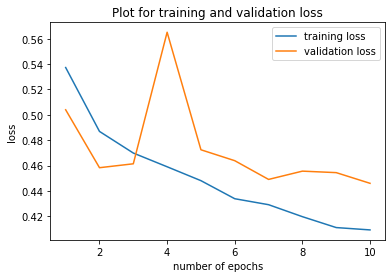

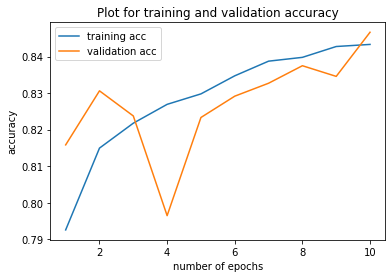

In [19]:
fig = plt.figure()
plt.plot(range(1, epochs+1), loss, label ='training loss')
plt.plot(range(1, epochs+1), val_loss_list, label ='validation loss')
plt.title("Plot for training and validation loss")
plt.xlabel("number of epochs")
plt.ylabel("loss")
plt.legend()
plt.show()

fig = plt.figure()
plt.plot(range(1, epochs+1), accuracy, label ='training acc')
plt.plot(range(1, epochs+1), val_accuracy_list, label ='validation acc')
plt.title("Plot for training and validation accuracy")
plt.xlabel("number of epochs")
plt.ylabel("accuracy")
plt.legend()
plt.show()

In [24]:
model.load_state_dict(torch.load('GPT2.pt'))

<All keys matched successfully>

In [25]:
test_labels, test_true_labels, test_loss = validate(test_dataloader, device)
test_acc= accuracy_score(test_true_labels, test_labels)
print(classification_report(test_true_labels,test_labels))

  0%|          | 0/188 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.80      0.84      0.82      2000
           1       0.85      0.78      0.81      2000
           2       0.85      0.87      0.86      2000

    accuracy                           0.83      6000
   macro avg       0.83      0.83      0.83      6000
weighted avg       0.83      0.83      0.83      6000



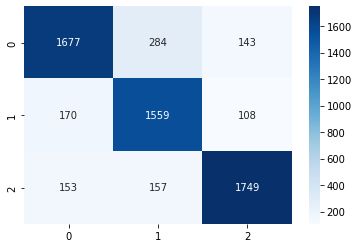

In [26]:
sns.heatmap(confusion_matrix(test_labels,test_true_labels), annot=True, fmt='.0f', cmap=plt.cm.Blues)
plt.show()